In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import os


INPUT_DIR = "input/UD_English-EWT"

## Dataset

In [2]:
import conllu
import itertools


def conllu_to_pd(file_path: str) -> pd.DataFrame:
    print("\tReading data...")
    with open(file_path, "r") as file:
        data = file.read()
    
    print("\tParsing data...")
    conllu_sentences = conllu.parse(data)
    
    print("\tGetting words...")
    words = [[word["form"].lower() for word in sentence] for sentence in tqdm(conllu_sentences)]
    
    print("\tGetting POS tags...")
    pos = [[word["upos"] for word in sentence] for sentence in tqdm(conllu_sentences)]
    
    print("\tGetting Sentence ids...")
    sent_ids = [[sent.metadata["sent_id"]]*len(sent) for sent in tqdm(conllu_sentences)]

    return pd.DataFrame({"words": itertools.chain.from_iterable(words),
                         "pos": itertools.chain.from_iterable(pos),
                         "sent_id": itertools.chain.from_iterable(sent_ids)})

In [3]:
print("Loading training dataset...")
train_df = conllu_to_pd(os.path.join(INPUT_DIR, "en_ewt-ud-train.conllu"))
print("Loading validation dataset...")
val_df = conllu_to_pd(os.path.join(INPUT_DIR, "en_ewt-ud-dev.conllu"))
print("Loading test dataset...")
test_df = conllu_to_pd(os.path.join(INPUT_DIR, "en_ewt-ud-test.conllu"))

print(f"Training data shape: {train_df.shape}\nValidation data shape: {val_df.shape}\nTest data shape: {test_df.shape}")

Loading training dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/12544 [00:00<?, ?it/s]

Loading validation dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2001 [00:00<?, ?it/s]

Loading test dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2077 [00:00<?, ?it/s]

Training data shape: (207227, 3)
Validation data shape: (25511, 3)
Test data shape: (25450, 3)


In [4]:
train_df

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029


### Statistics

In [5]:
def length_sentences(df: pd.DataFrame) -> float:
    lengths = df.groupby(["sent_id"]).agg(lambda x: len(x))
    return lengths.words

train_length = length_sentences(train_df)
val_length = length_sentences(val_df)
test_length = length_sentences(test_df)

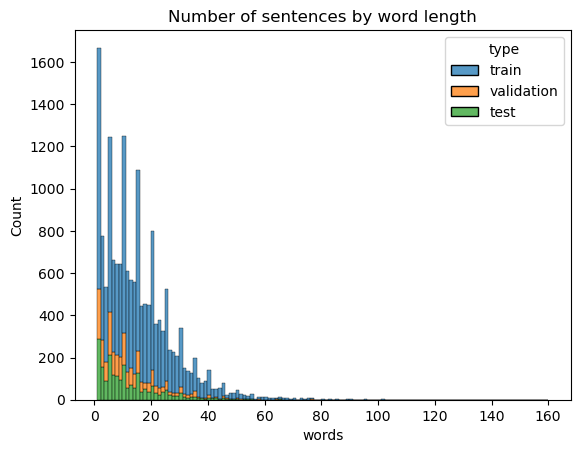

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


stats_df = pd.DataFrame({"words": pd.concat([train_length, val_length, test_length], ignore_index=True),
                        "type": len(train_length)*["train"] +
                         len(val_length)*["validation"] + 
                         len(test_length)*["test"]})

sns.histplot(x="words", 
             hue="type", 
             data=stats_df, 
             multiple="stack")

plt.title("Number of sentences by word length")
plt.show()

In [7]:
train_length.describe()

count    12544.000000
mean        16.520010
std         12.551839
min          1.000000
25%          7.000000
50%         14.000000
75%         23.000000
max        160.000000
Name: words, dtype: float64

In [8]:
val_length.describe()

count    2001.000000
mean       12.749125
std        10.564707
min         1.000000
25%         5.000000
50%        10.000000
75%        17.000000
max        77.000000
Name: words, dtype: float64

In [9]:
test_length.describe()

count    2077.00000
mean       12.25325
std        10.74451
min         1.00000
25%         4.00000
50%         9.00000
75%        17.00000
max        84.00000
Name: words, dtype: float64

In [10]:
print(f"Vocabulary size: {len(set(train_df.words))}")

Vocabulary size: 17113


In [11]:
print(f"Total word count:\nTraining: {train_df.shape[0]}"
      f"\nValidation: {val_df.shape[0]}"
      f"\nTesting: {test_df.shape[0]}")

Total word count:
Training: 207227
Validation: 25511
Testing: 25450


In [12]:
print(f"Total sentence count:\nTraining: {len(set(train_df.sent_id))}"
      f"\nValidation: {len(set(val_df.sent_id))}"
      f"\nTesting: {len(set(test_df.sent_id))}")

Total sentence count:
Training: 12544
Validation: 2001
Testing: 2077


## Stats-driven preprocessing

In [13]:
def exclude_small_sentences(conllu_df: pd.DataFrame, min_len: int) -> pd.DataFrame:
    assert 1 <= min_len
    
    length_df = length_sentences(conllu_df)
    valid_length_df = length_df[length_df >= min_len]
    valid_ids = set(valid_length_df.index)
    return conllu_df[conllu_df.sent_id.isin(valid_ids)]

In [14]:
MIN_SENTENCE_LENGTH = 5

train_df_filt = exclude_small_sentences(train_df, MIN_SENTENCE_LENGTH)
val_df_filt = exclude_small_sentences(val_df, MIN_SENTENCE_LENGTH)
test_df_fit = exclude_small_sentences(test_df, MIN_SENTENCE_LENGTH)

train_df_filt

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029
